In [709]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce
import re as re

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler



from sklearn.multiclass import  OneVsRestClassifier

from sklearn_pandas import DataFrameMapper
from sklearn_pandas import CategoricalImputer
from sklearn.pipeline import FeatureUnion

from sklearn.pipeline import Pipeline
 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import roc_auc_score

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
import gc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

import warnings
warnings.filterwarnings('ignore')


In [499]:
def reduce_mem(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [500]:
train = pd.read_csv("DataSet/application_train.csv")
test = pd.read_csv("DataSet/application_test.csv")
test = reduce_mem(test)
train = reduce_mem(train)

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


##### I realize the CODE_GENDER=="XNA" (only 4 observations with TARGET of 0) doesn't show up in the test data, but it's messing up with the label encoder, so I droped them all along.


In [369]:
train = train.drop(index = train.loc[train.CODE_GENDER=="XNA"].index)

In [370]:
def encode(df):
    le = LabelEncoder()
    oe = OneHotEncoder()
    le_col=[]
    for col in df:
        if df[col].dtype =="object":
            if df[col].nunique()==2:
                df[col].replace(np.nan, "NAN", inplace=True)
                le_col.append(col)
                le.fit(df[col])
                df[col] = le.transform(df[col])
    print("These {} columns ({}) are label encoded".format(len(le_col), le_col))
    print("Dimensions before OneHotEncoding : {}".format(df.shape))
    df = pd.get_dummies(df)
    print("Dimensions after OneHotEncoding : {}".format(df.shape))
    
    return df
                
train =encode(train)
train.head()
test = encode(test)
test.head()

These 5 columns (['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']) are label encoded
Dimensions before OneHotEncoding : (307507, 122)
Dimensions after OneHotEncoding : (307507, 240)
These 5 columns (['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE']) are label encoded
Dimensions before OneHotEncoding : (48744, 121)
Dimensions after OneHotEncoding : (48744, 237)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_block of flats,HOUSETYPE_MODE_specific housing,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden
0,100001,0,0,0,1,0,135000.0,568800.0,20560.5,450000.0,...,1,0,0,0,0,0,0,0,1,0
1,100005,0,1,0,1,0,99000.0,222768.0,17370.0,180000.0,...,0,0,0,0,0,0,0,0,0,0
2,100013,0,1,1,1,0,202500.0,663264.0,69777.0,630000.0,...,0,0,0,0,0,0,0,0,0,0
3,100028,0,0,0,1,2,315000.0,1575000.0,49018.5,1575000.0,...,1,0,0,0,0,0,0,1,0,0
4,100038,0,1,1,0,1,180000.0,625500.0,32067.0,625500.0,...,0,0,0,0,0,0,0,0,0,0


In [371]:
def align(train, test):
    
    print(" Shape of train data before alinging: {}".format(train.shape),"\n", 
         "Shape of test data before alinging: {}".format(test.shape))
    target = train["TARGET"]
    train, test = train.align(test, join="inner", axis =1)
    train["TARGET"] = target
    print(" Shape of train data after alinging: {}".format(train.shape), "\n", 
     "Shape of test data after alinging: {}".format(test.shape))
    return train, test
train, test = align(train, test)

 Shape of train data before alinging: (307507, 240) 
 Shape of test data before alinging: (48744, 237)
 Shape of train data after alinging: (307507, 238) 
 Shape of test data after alinging: (48744, 237)


In [372]:
def anomaly_correction(df, feature = "DAYS_EMPLOYED", integer=365243):
    df['Birth_ANOMALY'] = (df[feature]==integer).astype(int)

    df[feature].replace({integer: np.nan}, inplace =True )
    return df
train = anomaly_correction(train, feature = "DAYS_EMPLOYED", integer=365243)
test = anomaly_correction(test, feature = "DAYS_EMPLOYED", integer=365243)

In [373]:
# Changing the negative values for some features, which should be positive, into positive.
train[["DAYS_EMPLOYED","DAYS_BIRTH"]] = train[["DAYS_EMPLOYED","DAYS_BIRTH"]].apply(lambda x: x*(-1))
test[["DAYS_EMPLOYED","DAYS_BIRTH"]]= test[["DAYS_EMPLOYED","DAYS_BIRTH"]].apply(lambda x: x*(-1))

In [284]:
corr = train.corr()['TARGET'].sort_values()
print("Negatively correlated features are:\n",corr.head(20))

KeyboardInterrupt: 

In [35]:
print("Positively correlated features are:\n",corr.tail(20))

Positively correlated features are:
 NAME_HOUSING_TYPE_With parents                       0.029965
OCCUPATION_TYPE_Drivers                              0.030303
DEF_60_CNT_SOCIAL_CIRCLE                             0.031295
DEF_30_CNT_SOCIAL_CIRCLE                             0.032261
LIVE_CITY_NOT_WORK_CITY                              0.032517
OWN_CAR_AGE                                          0.037611
DAYS_REGISTRATION                                    0.041976
OCCUPATION_TYPE_Laborers                             0.043017
FLAG_DOCUMENT_3                                      0.044341
REG_CITY_NOT_LIVE_CITY                               0.044394
FLAG_EMP_PHONE                                       0.045984
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049822
REG_CITY_NOT_WORK_CITY                               0.050992
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER                                          0.054710
DAYS_LAST_PHONE_CHANGE           

In [12]:
def features_engd(features, df_train, df_test, degree):
    """ Features are given as a list."""
    df_train_eng = df_train[features]
    df_test_eng = df_test[features]
    
    # Imputations
    imputer = Imputer(strategy='mean')
    # Instantiating polynomialfeaures
    pf = PolynomialFeatures(degree, include_bias =False)
    
    df_train_eng =imputer.fit_transform(df_train_eng)
    df_train_eng =pf.fit_transform(df_train_eng)
    
    df_test_eng =imputer.transform(df_test_eng)
    df_test_eng =pf.transform(df_test_eng)
    print("Shape of the Engineered Treaining Data: {}".format(df_train_eng.shape))
    print("Shape of the Engineered Test Data: {}".format(df_test_eng.shape))
    print("First 15 Engineered Features: {}".format(pf.get_feature_names(input_features = features)[:15]))
    
    # Converting the engineered features into a data frame
    df_train_eng = pd.DataFrame(df_train_eng, columns=pf.get_feature_names(input_features = features))
    df_test_eng = pd.DataFrame(df_test_eng, columns=pf.get_feature_names(input_features = features))

        
    # Now merging the engineered dataframes
    df_train_eng["SK_ID_CURR"] =df_train["SK_ID_CURR"]
    df_test_eng["SK_ID_CURR"] =df_test["SK_ID_CURR"]
    
    
    df_train = df_train.merge(df_train_eng, how= "left", on = "SK_ID_CURR")
    df_test = df_test.merge(df_test_eng, how= "left", on = "SK_ID_CURR")
        
    # Aligning the engineered train and test data
    if df_train.shape != df_test.shape:
        df_train, df_test = align(df_train, df_test)
    
    # Adding the "TARGET" features to the engineered dataframe 
    df_train_eng["TARGET"] =df_train["TARGET"]
    
    return df_train_eng, df_test_eng, df_train, df_test

features = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3',
            "DAYS_BIRTH","DAYS_EMPLOYED", "NAME_EDUCATION_TYPE_Higher education",
            "ORGANIZATION_TYPE_XNA", "Birth_ANOMALY","FLOORSMAX_AVG"]

train_eng, test_eng, df_eng_train, df_eng_test = features_engd(features, train, test, degree=3)

Shape of the Engineered Treaining Data: (307507, 219)
Shape of the Engineered Test Data: (48744, 219)
First 15 Engineered Features: ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'NAME_EDUCATION_TYPE_Higher education', 'ORGANIZATION_TYPE_XNA', 'Birth_ANOMALY', 'FLOORSMAX_AVG', 'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2', 'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH', 'EXT_SOURCE_1 DAYS_EMPLOYED', 'EXT_SOURCE_1 NAME_EDUCATION_TYPE_Higher education']
 Shape of train data before alinging: (307507, 458) 
 Shape of test data before alinging: (48744, 457)
 Shape of train data after alinging: (307507, 458) 
 Shape of test data after alinging: (48744, 457)


In [13]:
eng_fts = ["EXT_SOURCE_2 EXT_SOURCE_3","EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3",
           "EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH", "EXT_SOURCE_2^2 EXT_SOURCE_3", "EXT_SOURCE_2 EXT_SOURCE_3^2"]
df_train_eng2, df_test_eng2, eng_train2, eng_test2 = features_engd(eng_fts, eng_train, eng_test, degree=3)

NameError: name 'eng_train' is not defined

In [163]:
test.columns

Index(['SK_ID_CURR', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'HOUSETYPE_MODE_specific housing', 'HOUSETYPE_MODE_terraced house',
       'WALLSMATERIAL_MODE_Block', 'WALLSMATERIAL_MODE_Mixed',
       'WALLSMATERIAL_MODE_Monolithic', 'WALLSMATERIAL_MODE_Others',
       'WALLSMATERIAL_MODE_Panel', 'WALLSMATERIAL_MODE_Stone, brick',
       'WALLSMATERIAL_MODE_Wooden', 'Birth_ANOMALY'],
      dtype='object', length=238)

In [185]:
def log_reg_kgl(train, test, file_name= "log_reg", C=1):
    
    #Extracting the ID columns
    submission_file = test[["SK_ID_CURR"]]
    train_id = train["SK_ID_CURR"]
    # Extracting the target columns
    target = train["TARGET"]
    #Dropping the id columns
    test = test.drop("SK_ID_CURR",axis =1)
    #Droping the id and target columns
    train = train.drop(["TARGET","SK_ID_CURR"], axis=1)
    train_cols = train.columns
    
    pl = Pipeline([
        ("imputaton", Imputer(strategy="median")),
        ("scale", MinMaxScaler(feature_range=(0, 1))),
        ("clf", OneVsRestClassifier(estimator=LogisticRegression(C=C,class_weight=None,
                                                                 dual=False, fit_intercept=True,
                                                                 intercept_scaling=1, max_iter=100
                                                                 ,multi_class='ovr', n_jobs=1, 
                                                                 penalty='l2', random_state=4,
                                                                 solver='liblinear', tol=0.0001, 
                                                                 verbose=0, warm_start=False)))
    ])
    pl.fit(train,target)
    test_proba = pl.predict_proba(test)
    submission_file["TARGET"]  =test_proba[:,1]
    submission_file.to_csv(file_name + '.csv', index = False)
    
    return submission_file

def log_reg_rocauc(train, C=1):
# Here I am building a pipeline
    test = train["TARGET"].values
    train = train.drop(["TARGET","SK_ID_CURR"], axis=1).values

    X_train, X_test, y_train, y_test = train_test_split(train,test,
                                                        test_size=0.2,
                                                        stratify=test,
                                                        random_state= 42)
    pl = Pipeline([
        ("imputaton", Imputer(strategy="median")),
        ("scale", MinMaxScaler(feature_range=(0, 1))),
        ("clf", OneVsRestClassifier(estimator=LogisticRegression(C=C,class_weight=None,
                                                                 dual=False, fit_intercept=True,
                                                                 intercept_scaling=1, max_iter=100,
                                                                 multi_class='ovr', n_jobs=1, 
                                                                 penalty='l2', random_state=4,
                                                                 solver='liblinear', tol=0.0001, 
                                                                 verbose=0, warm_start=False)))
    ])
    pl.fit(X_train, y_train)
    y_proba = pl.predict_proba(X_test)[:,1]
    rocauc = roc_auc_score(y_test, y_proba)
    print("ROC_AUC Score is {:.3f}".format(rocauc))
    return rocauc


In [179]:
submission_file = log_reg_kgl(train, test, file_name= "log_reg", C=1)

/Users/Antara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [186]:
log_reg_rocauc(train, C=1)

ROC_AUC Score is 0.749


0.7485176040194765

In [407]:
pd.get_dummies(train).shape

(307507, 239)

In [459]:
def find_categorical_fetures(df):
    """This functin takes a dataframe and return a list of catergorical columns.
    """
    return df.columns[df.dtypes=="object"].tolist()
train_categorical_features= find_categorical_fetures(train)


['NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'OCCUPATION_TYPE',
 'WEEKDAY_APPR_PROCESS_START',
 'ORGANIZATION_TYPE',
 'FONDKAPREMONT_MODE',
 'HOUSETYPE_MODE',
 'WALLSMATERIAL_MODE',
 'EMERGENCYSTATE_MODE']

In [465]:
random_df = pd.DataFrame({"Animals":["dog","cat","tiger","Lion"],
                          "Family":["Antara","Zahid","Arvin", np.nan],
                          "Integer":[1,2,3,4]})
catagorical_features = random_df.columns[random_df.dtypes=="object"].tolist()
#random_df  = random_df[catagorical_features].astype(str).apply(lambda x: LabelEncoder().fit_transform(x))
random_df

,Animals,Family,Integer
0,dog,Antara,1
1,cat,Zahid,2
2,tiger,Arvin,3
3,Lion,NaN,4


In [466]:
pd.get_dummies(random_df)

,Integer,Animals_Lion,Animals_cat,Animals_dog,Animals_tiger,Family_Antara,Family_Arvin,Family_Zahid
0,1,0,0,1,0,1,0,0
1,2,0,1,0,0,0,0,1
2,3,0,0,0,1,0,1,0
3,4,1,0,0,0,0,0,0


In [446]:
pl = Pipeline([
    ("imutation", Imputer()),
         ("le", LabelEncoder)
])

#pl.fit_transform(random_df)

train.columns[train.dtypes=="object"]

Index([], dtype='object')

In [93]:
log_reg_rocauc(eng_train2, C=1)

ROC_AUC Score is 0.7510514312629597


0.7510514312629597

In [710]:
class HomeCreditFraud(object):
    
    def __init__(self):
        pass
        
        
    def find_categorical_fetures(self, df):
        """
        This function takes a dataframe and return a list of catergorical columns.

        """
    
        categorical_features_list = df.columns[df.dtypes=="object"].tolist()
    
        return categorical_features_list
    
    def encoder(self,df, encoder ="ohe"):
        """
        encoder: str, default ="ohe", {"ohe": OneHotEncoding, "le":LabelEncoding}
        scaler: str, default ="MinMaxScaler",{"MinMaxScaler","StandardScaler" }
        n_folds: number of folds for cross validation. 
    
        """
    
        indices_for_columns_label_encoded =[]
        
        if encoder=="ohe":
            df = pd.get_dummies(df)

        elif encoder =="le":
            le = LabelEncoder()
            categorical_features = self.find_categorical_fetures(df)
            df[categorical_features] = df[categorical_features].astype(str).apply(
                lambda x: le.fit_transform(x)
            )
            

        else:
            raise ValueError("The encoder has to be either 'ohe' or 'le' ")
            
        return df
    
    def align_train_test(self, train, test, target_column_name ="TARGET"):
        
        """ 
        
        Parameters:
        ----------
            train: a dataframe of training smaples containing features and the target column.
            test: a dataframe of testing sample containing features.
            target_column ="TARGET"(default), but specify the target_column if different.
        
        """
        

        print(" Shape of train data before alinging: {}".format(train.shape),"\n", 
             "Shape of test data before alinging: {}".format(test.shape))
        
        target_column = train[target_column_name]
        train, test = train.align(test, join="inner", axis =1)
        train[target_column_name] = target_column
        print(" Shape of train data after alinging: {}".format(train.shape), "\n", 
         "Shape of test data after alinging: {}".format(test.shape))
        
        return train, test

    
    def plot_hist_categorical_features_hue_target(self, df, target_column_name ="TARGET"):
        categorical_features = self.find_categorical_features(df)
        df =df[categorical_fearues]
        fig, axes = plt.subplots(figsize=(10,10))
        
        sns.barplot()
    
    def lgboost_model(self, train, test,
                      encoder = "ohe", n_folds_cv =3,
                      id_column_name = "SK_ID_CURR",
                      target_column_name ="TARGET"):
        
        """
        Train and test a light gradient boosting model using KFold cross validation.
        
        train: a dataframe of training smaples containing features and the target column.
        test: a dataframe of testing sample containing features.
        
        """

        
        #Extracting the ID columns
        train_id = train[id_column_name]
        test_id = test[id_column_name]


        # Extracting the target columns
        target = train[target_column_name]


        
        # Encoding train and test data
        train = self.encoder(train, encoder =encoder)
        test = self.encoder(test, encoder = encoder)
        print("{} encoded\n".format(encoder))
        
        # Aligning the train and test data
        train, test = self.align_train_test(train, test, target_column_name =target_column_name)
        
        #Droping the id and target columns
        train = train.drop([target_column_name,id_column_name], axis=1)
        test = test.drop(id_column_name,axis =1)
        
        if train.shape[1] == test.shape[1]:
            
            print("\nShape of the train and the test data {} after droping the id and target columns".format(train.shape))
        else:
            raise ValueError("Check the train and test data")
            
        # Extracting the categorical features
        categorical_features = self.find_categorical_fetures(train)
        
        # Extracting all feature names
        feature_names = train.columns.tolist()
        
        # converting into arrays
        train = train.values
        test = test.values
        

        
        
        # Instantiating kfold cross validation
        kfold = KFold(n_splits = n_folds_cv,
                                shuffle =True, random_state =42)
        
        # Creating an empty array for the feature importance values,
        #which will be extracted after training the model
        n_fold_feature_importance = np.zeros((len(feature_names),n_folds_cv))
        
        # Creating an empty array for the test prediction values for all folds.
        # The final prediction will be the average of all predicted values. 
        
        n_fold_test_predictions = np.zeros((test.shape[0],n_folds_cv))
        
        # # Creating an empty array for the validation prediction values for all folds.
        # This will be one dimensional  and equal to the shape of train.shape[0]
        validation_predictions = np.zeros(train.shape[0])
        
        # Recording validating and train scores for each fold validation
        train_scores =[]
        validation_scores =[]
        
        # Iterating over all cross validation sets
        for each_validation, (train_indices, validation_indices) in zip(range(n_folds_cv), kfold.split(train)):
            
            X_train, y_train = train[train_indices], target[train_indices]
            
            X_validation, y_validation = train[validation_indices], target[validation_indices]
            
            model =  lgb.LGBMClassifier(n_esitmators =10000,
                                      objective ="binary",
                                      class_weight = "balanced",
                                      learning_rate = 0.05,
                                      reg_alpha =0.1,
                                      reg_lambda =0.1,
                                        subsample = 0.8,
                                       n_jobs = -1,
                                       num_boost_round =1000)
            
            print("\nFitting the model")
            
            model.fit(X_train, y_train,
                     eval_metric ="auc",
                     eval_set =[(X_train, y_train), (X_validation, y_validation)],
                     eval_names = ["train", "validation"],
                     categorical_feature = categorical_features,
                     early_stopping_rounds =100, verbose =100)
            
            # Recording the best iteration
            best_iteration = model.best_iteration_
            #n_fold_validation_predictions = np.zeros(train.shape[0])
            
            print("\nPredicting the validation and test data")
            
            # Recording the feature importances, and test predictions
            n_fold_feature_importance[:,each_validation] = model.feature_importances_

            n_fold_test_predictions[:,each_validation] = model.predict_proba(
                test, num_iteration = best_iteration)[:,1]
            
            # Recording the validation predictions by the validation_indices
            validation_predictions[validation_indices] = model.predict_proba(
                X_validation, num_iteration = best_iteration)[:,1]
            
            # Recording the best score
            train_scores.append(model.best_score_["train"]["auc"])
            validation_scores.append(model.best_score_["validation"]["auc"])
            
            # Cleaning up the memory
            print("\nCleaning up the memory")
            gc.enable()
            del model, X_train, X_validation
            gc.collect()
            
        print("\nCreating data frames for metrics")
        # Averaging all predictions 
        test_predictions =n_fold_test_predictions.mean(axis =1)

        feature_importance = n_fold_feature_importance.mean(axis =1)
        
        # Making the submission dataframe
        submission = pd.DataFrame({id_column_name: test_id, 'TARGET': test_predictions})
        
        
        # Make the feature importance dataframe
        feature_importances = pd.DataFrame({'feature_names': feature_names, 'importance': feature_importance})
        
        # Overall validation score
        validation_auc = roc_auc_score(target, validation_predictions)
        
        # Adding the overall scores to the metrics
        validation_scores.append(validation_auc)
        train_scores.append(np.mean(train_scores))
        
        # Needed for creating dataframe of validation scores
        number_folds = list(range(n_folds_cv))
        number_folds.append('overall')

        # Dataframe of validation scores
        performance_table = pd.DataFrame({'number_fold': number_folds,
                                'train_scores': train_scores,
                                'validation_scores': validation_scores}) 
        
        return submission, feature_importances, performance_table
        
    
    def plot_feature_importance(self, df):
        
        plt.style.use('fivethirtyeight')
        # Normalize the feature impotances
        df['importance'] = df['importance'] / df['importance'].sum()


        # Initialize the matplotlib figure
        f, ax = plt.subplots(figsize=(6, 15))

        sns.barplot(x="importance", y="feature_names",
                    data=df.sort_values("importance", ascending=False)[:50],
                    label="Most Important Features", color="r")


        # Plot labeling
        plt.xlabel('Normalized Importance');
        plt.ylabel('Features');
        
        plt.title('Most Important Features')
        plt.show()
        
        
    def features_engineering(self, features,
                             df_train, df_test,
                             id_column_name = "SK_ID_CURR",
                             target_column_name ="TARGET",
                             degree =3 ):
        """ Features are given as a list."""
        df_train_eng = df_train[features]
        df_test_eng = df_test[features]

        # Imputations
        imputer = Imputer(strategy='mean')
        # Instantiating polynomialfeaures
        pf = PolynomialFeatures(degree, include_bias =False)

        df_train_eng =imputer.fit_transform(df_train_eng)
        df_train_eng =pf.fit_transform(df_train_eng)

        df_test_eng =imputer.transform(df_test_eng)
        df_test_eng =pf.transform(df_test_eng)
        print("Shape of the Engineered Treaining Data: {}".format(df_train_eng.shape))
        print("Shape of the Engineered Test Data: {}".format(df_test_eng.shape))
        print("First 15 Engineered Features: {}".format(pf.get_feature_names(input_features = features)[:15]))

        # Converting the engineered features into a data frame
        df_train_eng = pd.DataFrame(df_train_eng, columns=pf.get_feature_names(input_features = features))
        df_test_eng = pd.DataFrame(df_test_eng, columns=pf.get_feature_names(input_features = features))


        # Now merging the engineered dataframes
        df_train_eng[id_column_name] =df_train[id_column_name]
        df_test_eng[id_column_name] =df_test[id_column_name]


        df_train = df_train.merge(df_train_eng, how= "left", on = id_column_name)
        df_test = df_test.merge(df_test_eng, how= "left", on = id_column_name)

        # Aligning the engineered train and test data
        if df_train.shape != df_test.shape:
            df_train, df_test = self.align_train_test(df_train, df_test)

        # Adding the "TARGET" features to the engineered dataframe 
        df_train_eng[target_column_name] =df_train[target_column_name]

        return df_train_eng, df_test_eng, df_train, df_test
    
    def imputation_scaling(self, train,test,
                           target_column_name ="TARGET",
                           encoder ="ohe",
                           scaler = "MinMaxScaler"):
        
        if target_column_name == None:
            pass
        else:
            train =train.drop(target_column_name, axis =1)
            
        train = self.encoder(train, encoder =encoder)
        test = self.encoder(test, encoder =encoder)
        
        # Imputaing and scaling
        
        imputer = Imputer(strategy="median")
        
        if scaler =="MinMaxScaler":
            scaler = MinMaxScaler(feature_range=(0, 1))
        elif scaler == "StandardScaler":
            scaler = StandardScaler()
        else:
            raise ValueError("Scaler has to be eithr MinMaxScaler or StandardScaler")
        
        pl = Pipeline([
        ("imputaton", imputer),
        ("scale", scaler)
        ])

        train = pl.fit_transform(train)
        test = pl.transform(test)
        return train, test
        
        

hcf = HomeCreditFraud()

In [ ]:
hcf.df_train_eng, df_test_eng, df_train, df_test = lgb.features_engineering(top10_important_features,
                             train, test,
                             id_column_name = "SK_ID_CURR",
                             target_column_name ="TARGET",
                             degree =3 )

In [713]:
# Training with engineered features
submission, feature_importances, performance_table = hcf.lgboost_model(df_train, df_test, encoder='ohe')
submission.to_csv("lgbm_model_ohe_features_engineered.csv", index =False)

ohe encoded

 Shape of train data before alinging: (307511, 408) 
 Shape of test data before alinging: (48744, 407)
 Shape of train data after alinging: (307511, 408) 
 Shape of test data after alinging: (48744, 407)

Shape of the train and the test data (307511, 406) after droping the id and target columns

Fitting the model
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.786537	validation's auc: 0.756347
[200]	train's auc: 0.814241	validation's auc: 0.758029
Early stopping, best iteration is:
[164]	train's auc: 0.805257	validation's auc: 0.758132

Predicting the validation and test data

Cleaning up the memory

Fitting the model
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.787471	validation's auc: 0.754612
[200]	train's auc: 0.815282	validation's auc: 0.756788
[300]	train's auc: 0.837734	validation's auc: 0.756626
Early stopping, best iteration is:
[210]	train's auc: 0.817865	validation's auc: 0.756901

Predic

In [714]:
performance_table

,number_fold,train_scores,validation_scores
0,0,0.805257,0.758132
1,1,0.817865,0.756901
2,2,0.812542,0.755807
3,overall,0.811888,0.756886


#### It looks like the performance doesn't improve that much after features engineering. 

In [684]:

submission, feature_importances, performance_table = LGB.lgboost_model(train, test,encoder='ohe')
submission.to_csv("lgbm_model_ohe_no_preprocessing.csv", index =False)

ohe encoded

 Shape of train data before alinging: (307511, 123) 
 Shape of test data before alinging: (48744, 122)
 Shape of train data after alinging: (307511, 123) 
 Shape of test data after alinging: (48744, 122)

Shape of the train and the test data (307511, 121) after droping the id and target columns

Fitting the model
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.780533	validation's auc: 0.755948
[200]	train's auc: 0.804453	validation's auc: 0.75902
[300]	train's auc: 0.822816	validation's auc: 0.759023
Early stopping, best iteration is:
[263]	train's auc: 0.816388	validation's auc: 0.759263

Predicting the validation and test data

Cleaning up the memory

Fitting the model
Training until validation scores don't improve for 100 rounds.
[100]	train's auc: 0.781916	validation's auc: 0.753229
[200]	train's auc: 0.805042	validation's auc: 0.755672
[300]	train's auc: 0.823388	validation's auc: 0.756065
Early stopping, best iteration is:
[255]	tr

In [685]:
performance_table 

,number_fold,train_scores,validation_scores
0,0,0.816388,0.759263
1,1,0.815696,0.756146
2,2,0.803957,0.754867
3,overall,0.812014,0.756718


In [652]:
top10_important_features =feature_importances.sort_values("importance", ascending=False).feature_names.head(10).tolist()

In [ ]:
df_train_eng, df_test_eng, df_train, df_test

In [ ]:
# Import necessary modules
from sklearn_pandas import DataFrameMapper
from sklearn_pandas import CategoricalImputer

# Check number of nulls in each feature column
nulls_per_column = X.isnull().sum()
print(nulls_per_column)

# Create a boolean mask for categorical columns
categorical_feature_mask = X.dtypes == object

# Get list of categorical column names
categorical_columns = X.columns[categorical_feature_mask].tolist()

# Get list of non-categorical column names
non_categorical_columns = X.columns[~categorical_feature_mask].tolist()

# Apply numeric imputer
numeric_imputation_mapper = DataFrameMapper(
                                            [([numeric_feature],Imputer(strategy="median")) for numeric_feature in non_categorical_columns],
                                            input_df=True,
                                            df_out=True
                                           )

# Apply categorical imputer
categorical_imputation_mapper = DataFrameMapper(
                                                [(category_feature, CategoricalImputer()) for category_feature in categorical_columns],
                                                input_df=True,
                                                df_out=True
                                               )
# Import FeatureUnion
from sklearn.pipeline import FeatureUnion

# Combine the numeric and categorical transformations
numeric_categorical_union = FeatureUnion([
                                          ("num_mapper", numeric_imputation_mapper),
                                          ("cat_mapper", categorical_imputation_mapper)
                                         ])

# Create full pipeline
pipeline = Pipeline([
                     ("featureunion", numeric_categorical_union),
                     ("dictifier", Dictifier()),
                     ("vectorizer", DictVectorizer(sort=False)),
                     ("clf", xgb.XGBClassifier(max_depth=3))
                    ])

# Perform cross-validation
cross_val_scores = cross_val_score(pipeline, X, y, scoring="roc_auc", cv=3)

# Print avg. AUC
print("3-fold AUC: ", np.mean(cross_val_scores))


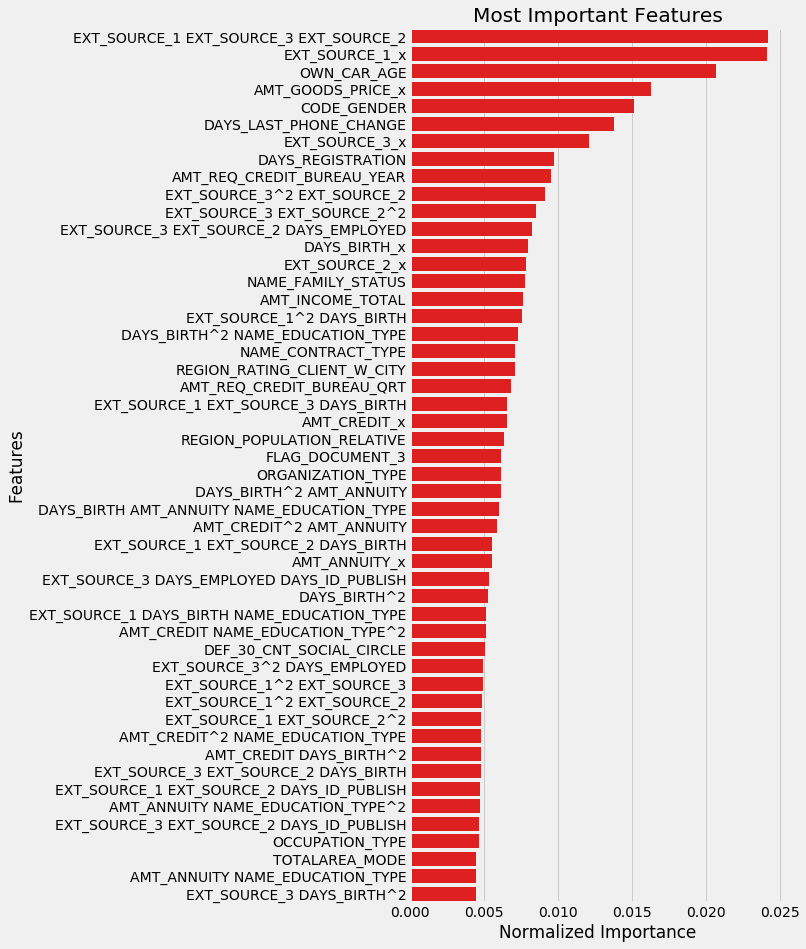

In [718]:
hcf.plot_feature_importance(feature_importances)

In [624]:
train = pd.read_csv("DataSet/application_train.csv")
test = pd.read_csv("DataSet/application_test.csv")
test = reduce_mem(test)
train = reduce_mem(train)

def anomaly_correction(df, feature = "DAYS_EMPLOYED", integer=365243):
    df['Birth_ANOMALY'] = (df[feature]==integer).astype(int)

    df[feature].replace({integer: np.nan}, inplace =True )
    return df
train = anomaly_correction(train, feature = "DAYS_EMPLOYED", integer=365243)
test = anomaly_correction(test, feature = "DAYS_EMPLOYED", integer=365243)

Memory usage of dataframe is 45.00 MB
Memory usage after optimization is: 14.60 MB
Decreased by 67.6%
Memory usage of dataframe is 286.23 MB
Memory usage after optimization is: 92.38 MB
Decreased by 67.7%


##### The above submission generated a score of 0.738, which is pretty close to my rocauc score of 0.749.

In [393]:
#def random_forest_classifier(train):
def random_forest_classifier(train, rocauc=False, kaggle =False, test= None):
    #Extracting the ID columns
    train_id = train["SK_ID_CURR"]
    # Extracting the target columns
    target = train["TARGET"]
    #Droping the id and target columns
    train = train.drop(["TARGET","SK_ID_CURR"], axis=1)
    train_cols = train.columns

    X_train, X_test, y_train, y_test = train_test_split(train,target,
                                                        test_size=0.2,
                                                        stratify=target,
                                                        random_state= 42)

    imputer = Imputer(strategy="median")
    scaler = MinMaxScaler(feature_range=(0, 1))
    # Instantiate rf
    rf = RandomForestClassifier(class_weight='balanced',
                                n_estimators=500,
                               max_depth =12,
                               max_features = "sqrt",
                               verbose =1,
                               random_state=2,
                               min_samples_leaf =2,
                               n_jobs=-1)

    if rocauc:
        pl = Pipeline([
        ("imputaton", Imputer(strategy="median")),
        ("scale", MinMaxScaler(feature_range=(0, 1)))
        ])

        X_train = pl.fit_transform(X_train)
        X_test = pl.transform(X_test) 

        # Fit bc to the training set
        rf.fit(X_train, y_train)
        # Predict test set labels
        y_pred = rf.predict_proba(X_test)[:,1]

        # Evaluate the test set RMSE
        roc_test =roc_auc_score(y_test, y_pred)

        # Print rmse_test
        print('Test set ROCAUC of RandomForest: {:.3f}'.format(roc_test))

        important_features = rf.feature_importances_
        # Create a pd.Series of features importances
        df_imp = pd.DataFrame({"features":train_cols, "importance":important_features})

        plt.style.use('fivethirtyeight')
        # Normalize the feature impotances
        df_imp['importance'] = df_imp['importance'] / df_imp['importance'].sum()


        # Initialize the matplotlib figure
        f, ax = plt.subplots(figsize=(6, 15))

        sns.barplot(x="importance", y="features",
                    data=df_imp.sort_values("importance", ascending=False)[:50],
                    label="Most Important Features", color="r")


        # Plot labeling
        plt.xlabel('Normalized Importance');
        plt.ylabel('Features');
        
        plt.title('Most Important Features')
        plt.show()
    
    if kaggle:

        submission_file = test[["SK_ID_CURR"]]
        #Dropping the id columns
        test = test.drop("SK_ID_CURR",axis =1)

        pl = Pipeline([
            ("imputaton", imputer),
            ("scale", scaler),
            ("clf", rf)
        ])        

        pl.fit(train,target)
        test_proba = pl.predict_proba(test)
        submission_file["TARGET"]  =test_proba[:,1]
        submission_file.to_csv('RandomForestClassifier.csv', index = False)

        return submission_file

    print("Please pass either rocauce =TRUE or kgl= True")

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  3.8min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.8s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    3.2s finished


Test set ROCAUC of RandomForest: 0.730


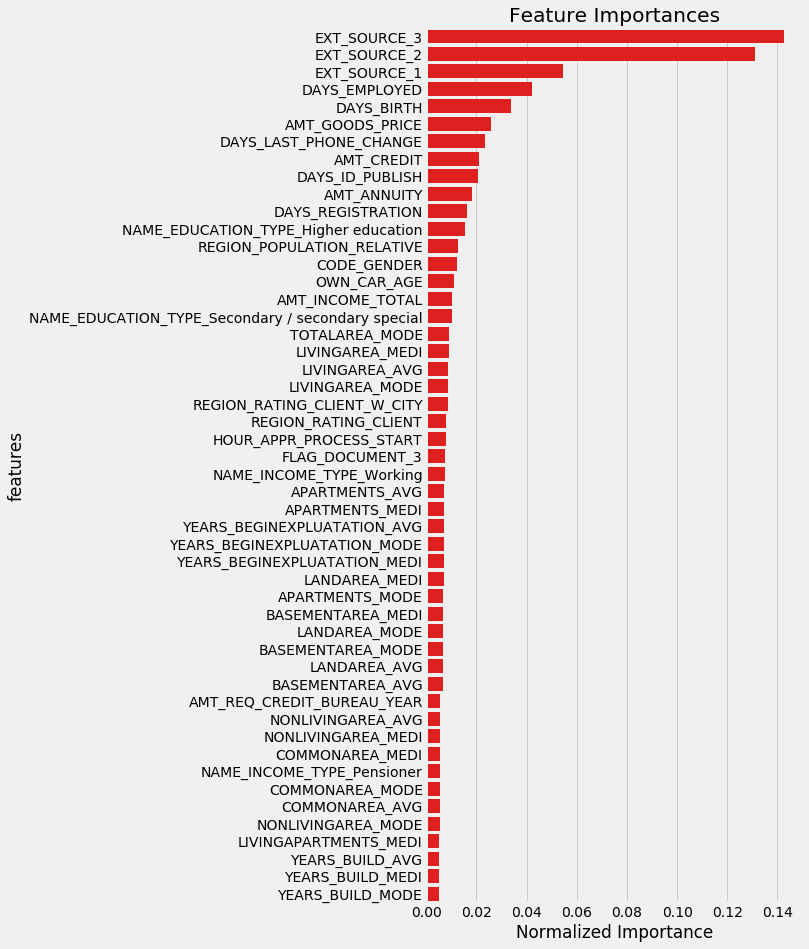

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:  4.5min
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  5.0min finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.9s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4)]: Done 500 out of 500 | elapsed:    2.5s finished


In [395]:
# Checking the ROCAUC score and creating the submission file. (Parameters were optimized by GridSearchCV)
submission_file_rf = random_forest_classifier(train, rocauc=True,kaggle=True, test=test)

In [ ]:
# Optimized parameters found from the GridSearchCV
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
        

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.0s finished


Test set ROCAUC of RandomForest: 0.689


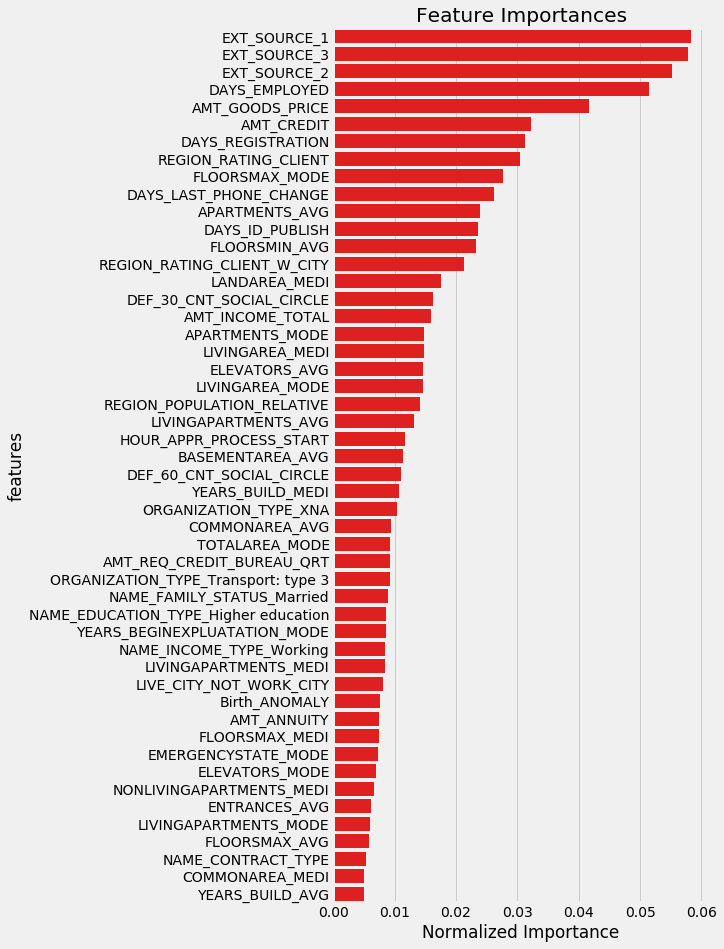

In [227]:
random_forest_classifier(train, sample = True)

In [14]:

def decision_tree_rocauc(train):
    test = train["TARGET"].values
    train = train.drop("TARGET", axis=1).values

    X_train, X_test, y_train, y_test = train_test_split(train,test,
                                                        test_size=0.2,
                                                        stratify=test,
                                                        random_state= 42)
    # Instantiating a DecisionTreeClassifier 'dt' with a maximum depth of 6
    dt = DecisionTreeClassifier(max_depth =4,criterion="gini", random_state=43, class_weight ="balanced")
    
    pl = Pipeline([
    ("imputaton", Imputer(strategy="median")),
    ("scale", MinMaxScaler(feature_range=(0, 1))),
    ("clf", OneVsRestClassifier(estimator=dt))
    ])
    
    pl.fit(X_train, y_train)
    y_proba = pl.predict_proba(X_test)[:,1]
    rocauc = roc_auc_score(y_test, y_proba)
    print("ROC_AUC Score is {}".format(rocauc))
    return y_proba

# Diagnosing bias-variance problem: to see how well our model fits data(i.e. if our model underfits or overfits the data)

def diagnose_bias_varaince(train):
    imputer= Imputer(strategy ="mean")

    
    test = train["TARGET"]
    train = train.drop("TARGET", axis=1)
    

    X_train, X_test, y_train, y_test = train_test_split(train,test,
                                                        test_size=0.2,
                                                        stratify=test,
                                                        random_state= 42)
    pl = Pipeline([
    ("imputaton", Imputer(strategy="median")),
    ("scale", MinMaxScaler(feature_range=(0, 1)))
    ])
    
    X_train = pl.fit_transform(X_train)
    X_test = pl.transform(X_test)
    
    # Instantiating a DecisionTreeClassifier 'dt' with a maximum depth of 6
    
    dt = DecisionTreeClassifier(max_depth =4,criterion="gini",
                                 random_state=43, class_weight ="balanced")
    # Calculate cv scores
    ROC_CV_scores = cross_val_score(dt, X_train, y_train, cv=2, 
                                  scoring='roc_auc', 
                                  n_jobs=-1)
    #min_samples_leaf=0.1,
    # Compute the 10-folds ROC_CV
    ROC_CV = ROC_CV_scores
    ROC_CV_mean = ROC_CV_scores.mean()

    # Print ROC_CV
    print('ROC_CV_mean: {:.2f}'.format(ROC_CV_mean))
    
    # Fit dt to the training set
    dt.fit(X_train, y_train)

    # Predict the labels of the training set
    y_pred = dt.predict(X_train)
    
    ROC_train = roc_auc_score(y_train, y_pred)
    print("ROC_train: {:.2f}".format(ROC_train))
    
    #y_proba = pl.predict_proba(X_test)[:,1]

    return ROC_CV, ROC_CV_mean, ROC_train

In [121]:
#max_depth =7,criterion="gini",#min_samples_leaf=0.26,
diagnose_bias_varaince(df_eng_train)

ROC_CV_mean: 0.69
ROC_train: 0.50


(array([0.68965739, 0.68310577, 0.68644907, 0.6740724 , 0.67802664,
        0.69459941, 0.69250055, 0.68221918, 0.69067273, 0.69700731]),
 0.6868310462260004,
 0.5)

In [406]:
kfold = KFold(n_splits =5,shuffle =True, random_state = 4)
for train_indices, valid_indices in kfold.split(train):
    pass#print(train_indices.shape, valid_indices.shape)
    
kfold.get_n_splits()
for index, feature in enumerate(train):
    print(index, feature)

0 SK_ID_CURR
1 NAME_CONTRACT_TYPE
2 CODE_GENDER
3 FLAG_OWN_CAR
4 FLAG_OWN_REALTY
5 CNT_CHILDREN
6 AMT_INCOME_TOTAL
7 AMT_CREDIT
8 AMT_ANNUITY
9 AMT_GOODS_PRICE
10 REGION_POPULATION_RELATIVE
11 DAYS_BIRTH
12 DAYS_EMPLOYED
13 DAYS_REGISTRATION
14 DAYS_ID_PUBLISH
15 OWN_CAR_AGE
16 FLAG_MOBIL
17 FLAG_EMP_PHONE
18 FLAG_WORK_PHONE
19 FLAG_CONT_MOBILE
20 FLAG_PHONE
21 FLAG_EMAIL
22 CNT_FAM_MEMBERS
23 REGION_RATING_CLIENT
24 REGION_RATING_CLIENT_W_CITY
25 HOUR_APPR_PROCESS_START
26 REG_REGION_NOT_LIVE_REGION
27 REG_REGION_NOT_WORK_REGION
28 LIVE_REGION_NOT_WORK_REGION
29 REG_CITY_NOT_LIVE_CITY
30 REG_CITY_NOT_WORK_CITY
31 LIVE_CITY_NOT_WORK_CITY
32 EXT_SOURCE_1
33 EXT_SOURCE_2
34 EXT_SOURCE_3
35 APARTMENTS_AVG
36 BASEMENTAREA_AVG
37 YEARS_BEGINEXPLUATATION_AVG
38 YEARS_BUILD_AVG
39 COMMONAREA_AVG
40 ELEVATORS_AVG
41 ENTRANCES_AVG
42 FLOORSMAX_AVG
43 FLOORSMIN_AVG
44 LANDAREA_AVG
45 LIVINGAPARTMENTS_AVG
46 LIVINGAREA_AVG
47 NONLIVINGAPARTMENTS_AVG
48 NONLIVINGAREA_AVG
49 APARTMENTS_MODE
50 BASE

It looks like our model overfitted the data!

    Over fitting occurs when the model captures the noise and the outliers in the data along with the underlying pattern. These models usually have high variance and low bias. These models are usually complex like Decision Trees, SVM or Neural Networks which are prone to over fitting.

    Under fitting occurs when the model is unable to capture the underlying pattern of the data. These models usually have a low variance and a high bias. These models are usually simple which are unable to capture the complex patterns in the data like Linear and Logistic Regressions.


In [123]:
# Let's decrease the max_depth
#max_depth =5,criterion="gini",#min_samples_leaf=0.26,
diagnose_bias_varaince(df_eng_train)

ROC_CV_mean: 0.69
ROC_train: 0.50


(array([0.68965739, 0.68310577, 0.68644907, 0.6740724 , 0.67802664,
        0.69459941, 0.69250055, 0.68221918, 0.69067273, 0.69700731]),
 0.6868310462260004,
 0.5)

In [125]:
# Let's decrease the max_depth
#max_depth =12,criterion="gini",#min_samples_leaf=0.26,
diagnose_bias_varaince(df_eng_train)

ROC_CV_mean: 0.69
ROC_train: 0.50


(array([0.68965739, 0.68310577, 0.68644907, 0.6740724 , 0.67802664,
        0.69459941, 0.69250055, 0.68221918, 0.69067273, 0.69700731]),
 0.6868310462260004,
 0.5)

In [139]:
# Let's decrease the max_depth
#max_depth =3,criterion="gini",#min_samples_leaf=0.26,
diagnose_bias_varaince(df_eng_train)

ROC_CV_mean: 0.67
ROC_train: 0.74


(array([0.66462286, 0.67136321]), 0.6679930347460612, 0.7373405412431122)

In [151]:
diagnose_bias_varaince(df_eng_train)

ROC_CV_mean: 0.72
ROC_train: 0.66


(array([0.71136419, 0.7203733 ]), 0.7158687403258506, 0.6600785169675889)

In [149]:
decision_tree_rocauc(df_eng_train)

ROC_AUC Score is 0.7212751473338236


array([0.49715591, 0.25093503, 0.82372626, ..., 0.53069744, 0.65081912,
       0.65081912])

In [24]:
# Ensemble Model
def ensemble_model(train, sample =1000):
    
    train = train.sample(sample, random_state =3)
    
    test = train["TARGET"]
    train = train.drop("TARGET", axis=1)
    

    X_train, X_test, y_train, y_test = train_test_split(train,test,
                                                        test_size=0.2,
                                                        stratify=test,
                                                        random_state= 42)
    pl = Pipeline([
    ("imputaton", Imputer(strategy="median")),
    ("scale", MinMaxScaler(feature_range=(0, 1)))
    ])
    
    X_train = pl.fit_transform(X_train)
    X_test = pl.transform(X_test)
    
    # Set seed for reproducibility
    SEED=1

    # Instantiate lr
    lr = LogisticRegression(random_state=SEED)
    # Instantiate knn
    knn = KNN(n_neighbors=35)
    # Instantiate dt
    dt = DecisionTreeClassifier(max_depth =6, criterion="gini",
                                class_weight ="balanced",
                                min_samples_leaf=0.13, 
                                random_state=SEED)
    #Instantiate svm
    svm = SVC(probability =True)

    # Define the list classifiers
    classifiers = [('Logistic Regression', lr), ('K Nearest Neighbours', knn),
                   ('Classification Tree', dt), ("Support Vector Machine", svm)]

    # Iterate over the pre-defined list of classifiers
    for clf_name, clf in classifiers:    

        # Fit clf to the training set
        clf.fit(X_train, y_train)    

        # Predict y_pred

        y_proba = clf.predict_proba(X_test)[:,1]
        
        rocauc_score = roc_auc_score(y_test, y_proba)
        
        # Evaluate clf's accuracy on the test set
        print('{:s} : {:.3f}'.format(clf_name, rocauc_score))

    # Instantiate a VotingClassifier vc 
    vc = VotingClassifier(estimators=classifiers, voting ="soft", n_jobs =-1)     

    # Fit vc to the training set
    vc.fit(X_train, y_train)   

    # Evaluate the test set predictions
    y_proba = vc.predict_proba(X_test)[:,1]

    # Calculate accuracy score
    rocauc_score = roc_auc_score(y_test, y_proba)
    print('Voting Classifier: {:.3f}'.format(rocauc_score))


In [25]:
ensemble_model(df_eng_train, sample =10000)

Logistic Regression : 0.689
K Nearest Neighbours : 0.524
Classification Tree : 0.636
Support Vector Machine : 0.565
Voting Classifier: 0.645


In [ ]:
def bagging_classifier(train, sample =1000):
    
    train = train.sample(sample, random_state =3)
    test = train["TARGET"]
    train = train.drop("TARGET", axis=1)
    

    X_train, X_test, y_train, y_test = train_test_split(train,test,
                                                        test_size=0.2,
                                                        stratify=test,
                                                        random_state= 42)
    pl = Pipeline([
    ("imputaton", Imputer(strategy="median")),
    ("scale", MinMaxScaler(feature_range=(0, 1)))
    ])
    
    X_train = pl.fit_transform(X_train)
    X_test = pl.transform(X_test)
    

    # Instantiate dt
    dt = DecisionTreeClassifier(random_state=1)

    # Instantiate bc
    bc = BaggingClassifier(base_estimator=dt,
                           n_estimators=50,
                           oob_score=True,
                           random_state=1)
    
    # Fit bc to the training set
    bc.fit(X_train, y_train)
    # Predict test set labels
    y_pred = bc.predict_proba(X_test)[:,1]

    # Evaluate acc_test
    acc_test = accuracy_score(y_test, y_pred)
    print('Test set accuracy of bc: {:.2f}'.format(acc_test))
    
    # Evaluate OOB accuracy
    acc_oob = bc.oob_score_

    # Print acc_test and acc_oob
    print('Test set accuracy: {:.3f}, OOB accuracy: {:.3f}'.format(acc_test, acc_oob))

In [ ]:
def log_reg(train, test, file_name= "log_reg", C=1):
# Here I am building a pipeline
    test = train["TARGET"].values
    train = train.drop("TARGET", axis=1).values

    test = pd.get_dummies(test).values
    pl = Pipeline([
        ("imputaton", Imputer(strategy="median")),
        ("scale", MinMaxScaler(feature_range=(0, 1))),
        ("clf", OneVsRestClassifier(estimator=LogisticRegression(C=C,class_weight=None,
                                                                 dual=False, fit_intercept=True,
                                                                 intercept_scaling=1, max_iter=100,
                                                                 multi_class='ovr', n_jobs=1, 
                                                                 penalty='l2', random_state=4,
                                                                 solver='liblinear', tol=0.0001, 
                                                                 verbose=0, warm_start=False)))
    ])
    pl.fit(trn,trt)
    proba = pl.predict_proba(test)
    submission = test[["SK_ID_CURR"]]
    submission["TARGET"]  =proba[:,1]
    submission = submission.to_csv(file_name + '.csv', index = False)

def random_forest_classifier_KG(train, test, file_name = "RandomForest_Predictions"):
   
    train_id = train["SK_ID_CURR"]
    train = train.sample(sample, random_state =3)
    test = train["TARGET"]
    train = train.drop(["TARGET", "SK_ID_CURR"], axis=1)
    df_train = train.copy()

    X_train, X_test, y_train, y_test = train_test_split(train,test,
                                                        test_size=0.2,
                                                        stratify=test,
                                                        random_state= 42)
    pl = Pipeline([
    ("imputaton", Imputer(strategy="median")),
    ("scale", MinMaxScaler(feature_range=(0, 1)))
    ])
    
    X_train = pl.fit_transform(X_train)
    X_test = pl.transform(X_test)
    
    
    # Instantiate rf
    
    rf = RandomForestRegressor(n_estimators=100,
                               max_depth =2,
                               max_features = "log2",
                               verbose =1,
                               random_state=2,
                               min_samples_leaf =2,
                               n_jobs=-1)
                           
    # Fit rf to the training set            
    rf.fit(X_train, y_train)
    
    # Predict the test set labels
    y_pred = rf.predict(X_test)

    # Evaluate the test set RMSE
    roc_test =roc_auc_score(y_test, y_pred)

    # Print rmse_test
    print('Test set ROCAUC of RandomForest: {:.2f}'.format(roc_test))
    
    # Create a pd.Series of features importances
    importances = pd.Series(data=rf.feature_importances_,
                            index= df_train.columns)

    # Sort importances
    importances_sorted = importances.sort_values(ascending=True)

    # Draw a horizontal barplot of importances_sorted
    importances_sorted[-20:].plot(kind='barh', color='lightgreen')
    plt.title('Features Importances')

    plt.show()
    return importances_sorted

In [81]:
def random_forest_classifier(train, sample =100):
   
    train_id = train["SK_ID_CURR"]
    train = train.sample(sample, random_state =3)
    test = train["TARGET"]
    train = train.drop(["TARGET", "SK_ID_CURR"], axis=1)
    df_train = train.copy()

    X_train, X_test, y_train, y_test = train_test_split(train,test,
                                                        test_size=0.2,
                                                        stratify=test,
                                                        random_state= 42)
    pl = Pipeline([
    ("imputaton", Imputer(strategy="median")),
    ("scale", MinMaxScaler(feature_range=(0, 1)))
    ])
    
    X_train = pl.fit_transform(X_train)
    X_test = pl.transform(X_test)
    
    
    # Instantiate rf
    
    rf = RandomForestRegressor(n_estimators=100,
                               max_depth =2,
                               max_features = "log2",
                               verbose =1,
                               random_state=2,
                               min_samples_leaf =2,
                               n_jobs=-1)
                           
    # Fit rf to the training set            
    rf.fit(X_train, y_train)
    
    # Predict the test set labels
    y_pred = rf.predict(X_test)

    # Evaluate the test set RMSE
    roc_test =roc_auc_score(y_test, y_pred)

    # Print rmse_test
    print('Test set ROCAUC of RandomForest: {:.2f}'.format(roc_test))
    
    # Create a pd.Series of features importances
    importances = pd.Series(data=rf.feature_importances_,
                            index= df_train.columns)

    # Sort importances
    importances_sorted = importances.sort_values(ascending=True)

    # Draw a horizontal barplot of importances_sorted
    importances_sorted[-20:].plot(kind='barh', color='lightgreen')
    plt.title('Features Importances')

    plt.show()
    return importances_sorted

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


Test set ROCAUC of RandomForest: 0.689


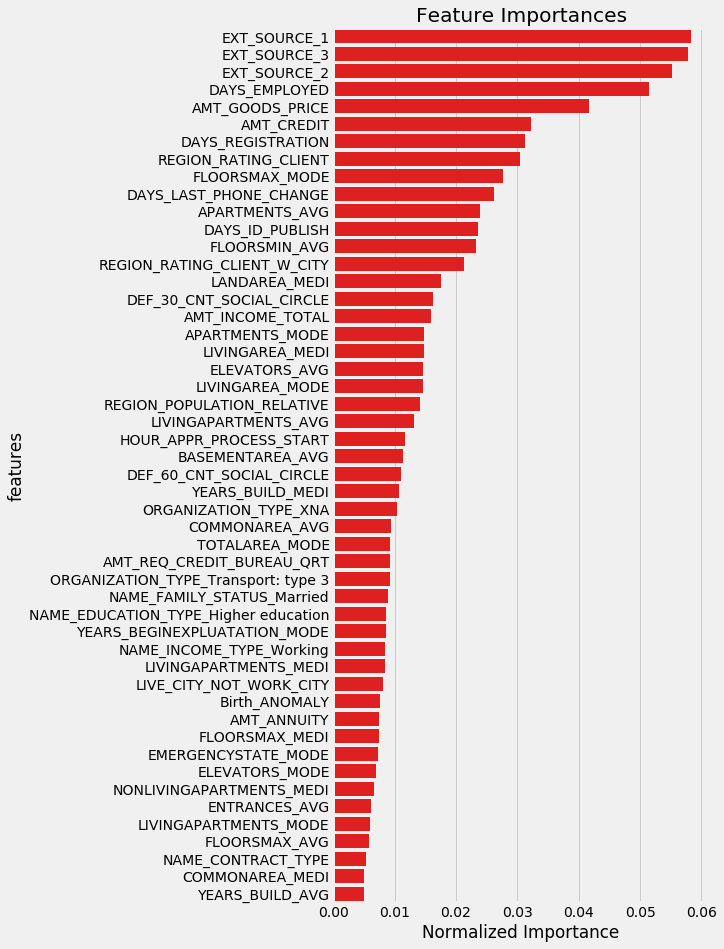

In [242]:
random_forest_classifier(train, sample =2000)

In [94]:
 def adaboost(train, sample =10000, estimator =10, learning_rate =1):
    
    train_id = train["SK_ID_CURR"]
    train = train.sample(sample, random_state =3)
    test = train["TARGET"]
    train = train.drop(["TARGET", "SK_ID_CURR"], axis=1)
    df_train = train.copy()

    X_train, X_test, y_train, y_test = train_test_split(train,test,
                                                        test_size=0.2,
                                                        stratify=test,
                                                        random_state= 42)
    pl = Pipeline([
    ("imputaton", Imputer(strategy="median")),
    ("scale", MinMaxScaler(feature_range=(0, 1)))
    ])
    
    X_train = pl.fit_transform(X_train)
    X_test = pl.transform(X_test)

    # Instantiate dt
    dt = DecisionTreeClassifier(max_depth=2, random_state=1)

    # Instantiate ada
    ada = AdaBoostClassifier(base_estimator=dt, n_estimators=estimator,
                             learning_rate =learning_rate, random_state=1)
    
    # Fit ada to the training set
    ada.fit(X_train, y_train)

    # Compute the probabilities of obtaining the positive class
    y_pred_proba = ada.predict_proba(X_test)[:,1]

    # Evaluate test-set roc_auc_score
    ada_roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print roc_auc_score
    print('ROC AUC score: {:.2f}'.format(ada_roc_auc))

In [97]:
adaboost(df_eng_train, sample =100000, n_estimatos =300, learning_rate =1)

ROC AUC score: 0.69


In [109]:
def gradient_boosting(train, sample =10000, n_estimators =10, learning_rate = 1):

    train_id = train["SK_ID_CURR"]
    train = train.sample(sample, random_state =3)
    test = train["TARGET"]
    train = train.drop(["TARGET", "SK_ID_CURR"], axis=1)
    df_train = train.copy()

    X_train, X_test, y_train, y_test = train_test_split(train,test,
                                                        test_size=0.2,
                                                        stratify=test,
                                                        random_state= 42)
    pl = Pipeline([
    ("imputaton", Imputer(strategy="median")),
    ("scale", MinMaxScaler(feature_range=(0, 1)))
    ])
    
    X_train = pl.fit_transform(X_train)
    X_test = pl.transform(X_test)
    
    
    gb = GradientBoostingClassifier(max_depth=4,subsample=0.7,
                                    max_features=0.75,n_estimators=n_estimators, 
                                    learning_rate= learning_rate,
                                    verbose =True, random_state=2)
    
    # Fit ada to the training set
    gb.fit(X_train, y_train)

    # Compute the probabilities of obtaining the positive class
    y_pred_proba = gb.predict_proba(X_test)[:,1]

    # Evaluate test-set roc_auc_score
    gb_roc_auc = roc_auc_score(y_test, y_pred_proba)

    # Print roc_auc_score
    print('ROC AUC score: {:.2f}'.format(gb_roc_auc))

In [106]:
gradient_boosting(df_eng_train, sample =100000, n_estimators =100, learning_rate = 0.1)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5505           0.0082            4.88m
         2           0.5399           0.0067            4.46m
         3           0.5366           0.0051            4.24m
         4           0.5307           0.0043            4.10m
         5           0.5265           0.0034            4.00m
         6           0.5227           0.0027            3.91m
         7           0.5250           0.0024            3.84m
         8           0.5202           0.0018            3.80m
         9           0.5211           0.0018            3.75m
        10           0.5187           0.0015            3.69m
        20           0.4988           0.0001            3.21m
        30           0.4951           0.0003            2.79m
        40           0.4924          -0.0000            2.38m
        50           0.4904          -0.0000            1.98m
        60           0.4841          -0.0001            1.67m
       

In [115]:
gradient_boosting(df_eng_train, sample =200000, n_estimators =300, learning_rate = 0.1)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1           0.5496           0.0090          180.55m
         2           0.5396           0.0068          151.38m
         3           0.5368           0.0055          115.59m
         4           0.5318           0.0042           95.64m
         5           0.5284           0.0035           84.14m
         6           0.5266           0.0028           75.25m
         7           0.5250           0.0025           69.18m
         8           0.5195           0.0021           66.53m
         9           0.5208           0.0019           63.14m
        10           0.5176           0.0015           74.01m
        20           0.5029           0.0006           57.86m
        30           0.4980           0.0004           50.11m
        40           0.4949           0.0002           42.71m
        50           0.4897           0.0001           37.66m
        60           0.4897           0.0000           33.89m
       

In [114]:
dt = DecisionTreeClassifier(random_state=1)
dt.get_params()
params_dt = {'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 1,
 'splitter': 'best'}
params_dt = {
             'max_depth': [2, 4, 6,8,10],
             'min_samples_leaf': [0.12, 0.14, 0.16, 0.18]
            }



# Instantiate grid_dt
grid_dt = GridSearchCV(estimator=dt,
                       param_grid=params_dt,
                       scoring='roc_auc',
                       cv=5,
                       n_jobs=-1)
# Extract the best estimator
best_model = grid_dt.best_estimator_

# Predict the test set probabilities of the positive class
y_pred_proba = best_model.predict_proba(X_test)[:,1]

# Compute test_roc_auc
test_roc_auc = roc_auc_score(y_test, y_pred_proba)

{'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': False,
 'random_state': 1,
 'splitter': 'best'}

In [389]:

def GridSearchRF(train):
    
    train_id = train["SK_ID_CURR"]
    #train = train.sample(sample, random_state =3)
    test = train["TARGET"]
    train = train.drop(["TARGET", "SK_ID_CURR"], axis=1)
    df_train = train.copy()

    X_train, X_test, y_train, y_test = train_test_split(train,test,
                                                        test_size=0.2,
                                                        stratify=test,
                                                        random_state= 42)
    pl = Pipeline([
    ("imputaton", Imputer(strategy="median")),
    ("scale", MinMaxScaler(feature_range=(0, 1)))
    ])
    
    X_train = pl.fit_transform(X_train)
    X_test = pl.transform(X_test)
    rf = RandomForestClassifier(class_weight ="balanced")
    params_rf = {'max_depth' :[2,4,8,12],
                 'n_estimators': [100, 350, 500],
                 'max_features': ['log2', 'auto', 'sqrt'],
                 'min_samples_leaf': [2, 5, 10, 30,], 
                 }
    # Instantiate grid_rf
    grid_rf = GridSearchCV(estimator=rf,
                           param_grid=params_rf,
                           cv=3,
                           verbose=1,
                           n_jobs=-1)
    grid_rf.fit(X_test, y_test)
    # Extract the best estimator
    best_model = grid_rf.best_estimator_

    # Predict the test set probabilities of the positive class
    y_pred_proba = best_model.predict_proba(X_test)[:,1]

    # Compute test_roc_auc
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    print("ROC score {:.3f}".format(test_roc_auc))
    print(best_model)
    return test_roc_auc, best_model, grid_rf

In [390]:
test_roc_auc, best_model, grid_rf =GridSearchRF(train)

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 62.4min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed: 235.7min finished


ROC score 0.908
RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=12, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=2,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


In [152]:
best_model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='log2', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

## Gradient Boosting (Light GBM and Xtreme GBM)

In [153]:
grid_rf.best_params_

{'max_depth': 4,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'n_estimators': 100}